In [1]:
# !pip install jours-feries-france -q
# !pip install vacances-scolaires-france -q

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import lightgbm
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

TARGETS = ["Available", "Charging", "Passive", "Other"]

In [3]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
def plot_feat_importance(clf, X):
    feature_imp = pd.DataFrame(
        sorted(zip(clf.feature_importances_, X.columns)),
        columns=['Value','Feature']
    )

    plt.figure(figsize=(12, 4))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.tight_layout()
    plt.show()

In [5]:
# data loading
df_data = pd.read_csv("../public_data/train.csv")
# df_test = pd.read_csv("../public_data/test.csv")

df_data['date'] = pd.to_datetime(df_data['date'])

df_train = df_data[(df_data["date"] < "2021-01-18") & (df_data["date"] > "2020-05-18")]
df_validation = df_data[df_data["date"] > "2021-01-18"]

df_train["day"] = pd.to_datetime(df_train["date"].dt.date)
df_validation["day"] = pd.to_datetime(df_validation["date"].dt.date)

In [6]:
def sae(y_true, y_pred):
    """Sum of Absolute errors"""
    return(sum(abs(y_true - y_pred)))

# Modeling

## Features

In [7]:
from jours_feries_france import JoursFeries

jf = list(JoursFeries.for_year(2020).values()) + list(JoursFeries.for_year(2021).values())

from vacances_scolaires_france import SchoolHolidayDates

holidays = SchoolHolidayDates()
hd = [k for k, v in holidays.holidays_for_year(2020).items() if v["vacances_zone_c"]] \
   + [k for k, v in holidays.holidays_for_year(2021).items() if v["vacances_zone_c"]]

df_train["is_jf"] = df_train["date"].dt.date.isin(jf)
df_train["is_hd"] = df_train["date"].dt.date.isin(hd)

df_validation["is_jf"] = df_validation["date"].dt.date.isin(jf)
df_validation["is_hd"] = df_validation["date"].dt.date.isin(hd)


In [8]:
# use monthly historical temperatures 
# (not very informative but helps capturing seasonality effect)

df = pd.read_csv("../paris-historical-temperature.csv", sep=";")
df["day"] = pd.to_datetime(df["observ_date"], dayfirst=True) + pd.tseries.offsets.Day(30)
df = df[df["day"] > "2020-01-01"]
df = df.set_index("day")
df = (
    df
    .reindex(pd.date_range("2020", "2022"))
    .ffill(limit=31)
    .reset_index()
    .rename(columns={"index": "day"})
)

### Add electricity consumption

In [9]:
paris_data = pd.read_json("/Users/paulemiledugnat/Downloads/téléchargement.json", lines=True)
paris_data = pd.concat([pd.Series(paris_data["fields"].values[i]) for i in range(paris_data.shape[0])], axis=1).T

paris_data = paris_data[["date", "heures", "consommation"]]

paris_data["day"] = pd.to_datetime(paris_data["date"], yearfirst=True)
paris_data["tod"] = paris_data["heures"].str.split(':').apply(lambda x: 4 * int(x[0]) + int(x[1]) // 15)
paris_data["consommation"] = paris_data["consommation"].astype(float)

paris_data = paris_data.drop(["heures", "date"], axis=1).sort_values(by=["day", "tod"])

paris_data = (
    paris_data
    .set_index(["day", "tod"])
    .reindex(pd.MultiIndex.from_product((paris_data["day"].unique(), range(96)), names=["day", "tod"]))
    .ffill()
    .reset_index()
)


In [11]:
df_train = pd.merge(
    df_train,
    paris_data,
    on=["day", "tod"],
)

df_validation = pd.merge(
    df_validation,
    paris_data,
    on=["day", "tod"]
)

### add interaction features

In [15]:
for df_ in [df_train, df_validation]:
    df_["tod-dow"] = df_["tod"].astype(str) + "-" + df_["dow"].astype(str)
    df_["tod-area"] = df_["tod"].astype(str) + "-" + df_["area"].astype(str)
    df_["dow-area"] = df_["dow"].astype(str) + "-" + df_["area"].astype(str)

### Add temperatures and one hot encode area

In [16]:
df_train = pd.merge(
    df_train,
    df[["day", "avg_day", "avg_night"]],
    on=["day"]
).drop("Station", axis=1)

df_train = pd.concat((
    df_train.drop("area", axis=1), 
    pd.get_dummies(df_train["area"])
), axis=1)

df_validation = pd.merge(
    df_validation,
    df[["day", "avg_day", "avg_night"]],
    on=["day"]
).drop("Station", axis=1)

df_validation = pd.concat((
    df_validation.drop("area", axis=1), 
    pd.get_dummies(df_validation["area"])
), axis=1)

In [17]:
df_train.head(2)

,date,Available,Charging,Passive,Other,tod,dow,trend,Latitude,Longitude,Postcode,day,is_jf,is_hd,consommation,tod-dow,tod-area,dow-area,avg_day,avg_night,east,north,south,west
0,2020-07-03,3,0,0,0,0,6,27,48.855667,2.354089,75004,2020-07-03,False,False,3258.0,0-6,0-south,6-south,24.0,14.4,0,0,1,0
1,2020-07-03,2,1,0,0,0,6,27,48.864240,2.397724,75020,2020-07-03,False,False,3258.0,0-6,0-east,6-east,24.0,14.4,1,0,0,0


In [18]:
df_validation.head(2)

,date,Available,Charging,Passive,Other,tod,dow,trend,Latitude,Longitude,Postcode,day,is_jf,is_hd,consommation,tod-dow,tod-area,dow-area,avg_day,avg_night,east,north,south,west
0,2021-01-18 00:15:00,2,0,1,0,1,2,19132,48.85567,2.354089,75004,2021-01-18,False,False,5569.0,1-2,1-south,2-south,9.0,5.2,0,0,1,0
1,2021-01-18 00:15:00,0,0,0,3,1,2,19132,48.86424,2.397724,75020,2021-01-18,False,False,5569.0,1-2,1-east,2-east,9.0,5.2,1,0,0,0


In [19]:
# prepare sample weights to add weight for recent data
# doesn't work
"""mean_val_date = df_validation.date.mean().date()
df_train["day_diff"] = (pd.Timestamp(mean_val_date) - df_train["date"]).dt.days

df_train["weight"] = 1 + df_train["day_diff"].rank(pct=True, ascending=False).div(2)

sample_weight = df_train["weight"].values

df_train = df_train.drop(["weight", "day_diff"], axis=1)"""

'mean_val_date = df_validation.date.mean().date()\ndf_train["day_diff"] = (pd.Timestamp(mean_val_date) - df_train["date"]).dt.days\n\ndf_train["weight"] = 1 + df_train["day_diff"].rank(pct=True, ascending=False).div(2)\n\nsample_weight = df_train["weight"].values\n\ndf_train = df_train.drop(["weight", "day_diff"], axis=1)'

In [20]:
import xgboost
import category_encoders as ce

  0%|          | 0/4 [00:00<?, ?it/s]

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[50]	training's l1: 0.71797	training's huber: 0.343429	valid_1's l1: 0.831716	valid_1's huber: 0.433437
[100]	training's l1: 0.680038	training's huber: 0.318864	valid_1's l1: 0.810412	valid_1's huber: 0.421905


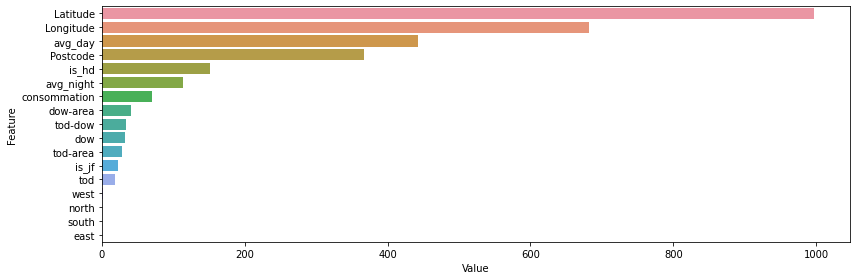

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[50]	training's l1: 0.313121	training's huber: 0.0981223	valid_1's l1: 0.380813	valid_1's huber: 0.127326
[100]	training's l1: 0.304915	training's huber: 0.0955118	valid_1's l1: 0.371195	valid_1's huber: 0.125547


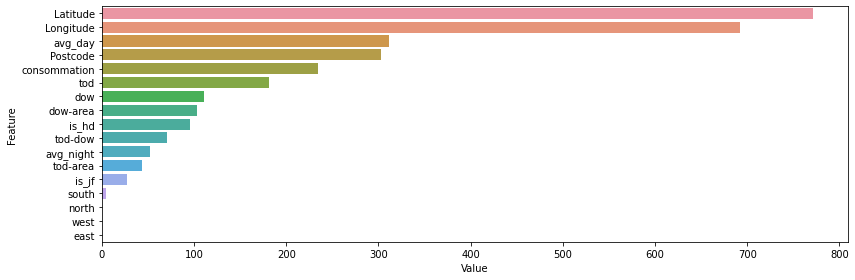

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[50]	training's l1: 0.330429	training's huber: 0.109942	valid_1's l1: 0.342719	valid_1's huber: 0.0976972
[100]	training's l1: 0.318595	training's huber: 0.105745	valid_1's l1: 0.342242	valid_1's huber: 0.100442


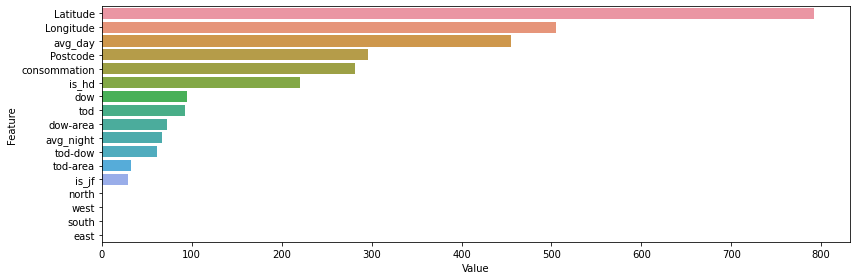

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[50]	training's l1: 0.465852	training's huber: 0.239943	valid_1's l1: 0.696464	valid_1's huber: 0.402167
[100]	training's l1: 0.420492	training's huber: 0.215126	valid_1's l1: 0.659481	valid_1's huber: 0.386224


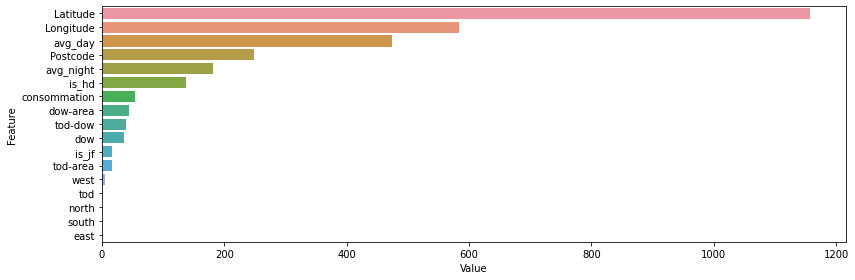

In [25]:
# training loop

y_preds = list()
models = list()
scores = list()

train_feats = df_train.drop(TARGETS + ["date", "day", "trend"], axis=1)
valid_feats = df_validation.drop(TARGETS + ["date", "day", "trend"], axis=1)

for target in tqdm(TARGETS):

    train_target = df_train[target]
    valid_target = df_validation[target]
    
    encoder = ce.TargetEncoder(cols=["tod-dow", "dow-area", "tod-area"])

    encoder.fit(train_feats, train_target)
    train_feats = encoder.transform(train_feats)
    valid_feats = encoder.transform(valid_feats)
    
    lgbm = lightgbm.LGBMRegressor(objective="huber", verbose=0)
    lgbm.fit(
        train_feats,
        train_target,
        eval_set=[
            (train_feats, train_target), 
            (valid_feats, valid_target)
        ],
        eval_metric="l1",
        verbose=50,
        categorical_feature=["Postcode"]
    )

    score = (
        np.around(np.mean(np.abs(lgbm.predict(valid_feats) - valid_target)), 2)
    )

    y_preds.append(lgbm.predict(valid_feats))
    models.append(lgbm)
    scores.append(score)
    
    plot_feat_importance(lgbm, train_feats)

In [26]:
scores

[0.81, 0.37, 0.34, 0.66]

# Global Pred

In [23]:
for k in range(4):
    true_target = pd.concat((df_train, df_validation), axis=0).groupby("date")[TARGETS[k]].sum()
    
    # true_target.plot()
    # plt.show()

    station_prediction = pd.DataFrame(y_preds[k], index=df_validation["date"]).reset_index()

    global_prediction = station_prediction.groupby(["date"])[0].sum().reset_index().rename(columns={0: TARGETS[k]})

    preds = pd.merge(
        global_prediction,
        true_target.reset_index(),
        on="date"
    ).assign(mae=lambda x: abs(x[f"{TARGETS[k]}_x"] - x[f"{TARGETS[k]}_y"]))

    print(f"{TARGETS[k]}: {preds['mae'].mean():.2f}")


Available: 10.03
Charging: 4.86
Passive: 9.27
Other: 16.00


In [ ]:
Available: 11.87
Charging: 4.94
Passive: 12.27
Other: 8.42